### ZTF Light Curve Plotting

Let's try plotting some light curves from that low luminosity sample to recreate [Das et al. 2025](https://arxiv.org/abs/2506.20068).

In [222]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from alerce.core import Alerce
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm
import time
import json
import glob
from astropy import units as u
import astropy.constants as c

In [178]:
### Matplotlib params
# Set global style parameters
mpl.rcParams.update({
    "xtick.direction": "in",   # x ticks go inward
    "ytick.direction": "in",   # y ticks go inward
    "xtick.top": True,         # show ticks on top
    "ytick.right": True,       # show ticks on right
    "xtick.minor.visible": True,  # show minor ticks if enabled
    "ytick.minor.visible": True,
    "xtick.major.size": 6,     # length of major ticks
    "ytick.major.size": 6,
    "xtick.minor.size": 3,     # length of minor ticks
    "ytick.minor.size": 3,
})

In [179]:
df = pd.read_csv('data/ZTF_alerce_alerts.csv')
df

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18aaszvfn,93,2072,58248.310775,59391.288310,False,False,40,-0.063799,0.865591,...,59391.288310,83.960486,215.782862,50.220817,0.000044,0.000022,NaN,NaN,NaN,correction_0.0.1
1,ZTF18abjndhh,66,397,58324.166528,58486.489676,False,False,11,0.377247,NaN,...,58486.489676,162.323148,173.179280,62.432761,0.000074,0.000027,NaN,NaN,NaN,corr_bulk_0.0.1
2,ZTF18abzrgim,32,75,58388.269190,58494.133542,False,False,26,0.336168,NaN,...,58494.133542,105.864352,346.885593,23.005797,0.000030,0.000021,NaN,NaN,NaN,corr_bulk_0.0.1
3,ZTF19aadnxnl,482,1220,58502.489664,58901.430382,False,False,109,0.255573,NaN,...,58901.430382,398.940718,203.811186,44.766284,0.000041,0.000025,NaN,NaN,NaN,corr_bulk_0.0.1
4,ZTF19aailepg,83,377,58514.464630,58661.200752,False,False,66,0.216761,NaN,...,58661.200752,146.736123,169.467734,30.156520,0.000039,0.000040,NaN,NaN,NaN,corr_bulk_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ZTF24aafqzur,55,943,60355.520359,60471.292118,True,False,36,NaN,NaN,...,60471.292118,115.771759,216.488345,-2.392265,0.008317,0.008309,NaN,NaN,NaN,24.5.1
104,ZTF24aagupsf,183,3955,60374.513438,60473.367002,False,False,56,NaN,NaN,...,60473.367002,89.952558,247.672867,44.511143,0.010341,0.007374,NaN,NaN,NaN,24.5.1
105,ZTF24aajxppf,113,2120,60416.479329,60555.171528,True,False,81,NaN,NaN,...,60555.171528,136.799097,269.590144,9.681528,0.038562,0.038013,NaN,NaN,NaN,24.5.2a6
106,ZTF24aaplfjd,174,2001,60460.465995,60581.460706,True,False,63,NaN,NaN,...,60581.460706,120.994711,14.505587,30.706595,0.098861,0.085000,NaN,NaN,NaN,24.5.2a6


In [ ]:
## Using a lot of Viraj's code from LSST CCA Summer School

# Color config for filters
colors = {1: "green", 2: "red"}
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}
sizes = {1: 30, 2: 60}


def query_all_detections(oid, client, page_size=10000):
    """Fetch all detection rows for a given oid from ALeRCE."""
    all_dets = []
    page = 1
    while True:
        dets = client.query_detections(
            oid, format='pandas', page=page, page_size=page_size
        )
        if dets.empty:
            break
        all_dets.append(dets)
        page += 1
    return pd.concat(all_dets, ignore_index=True) if all_dets else pd.DataFrame()


def query_all_nondetections(oid, client, page_size=10000):
    """Fetch all non-detection rows for a given oid from ALeRCE."""
    all_nd = []
    page = 1
    while True:
        nd = client.query_non_detections(
            oid, format='pandas', page=page, page_size=page_size
        )
        if nd.empty:
            break
        all_nd.append(nd)
        page += 1
    return pd.concat(all_nd, ignore_index=True) if all_nd else pd.DataFrame()

def plot_stamps(oid, lc_det, client):
    # Find first detection with a valid stamp
    if "has_stamp" not in lc_det.columns or lc_det["has_stamp"].sum() == 0:
        print(f"⚠️ No stamp available for {oid}")
        return

    try:
        candid = lc_det.loc[lc_det.has_stamp].sort_values("mjd").candid.iloc[0]
        stamps = client.get_stamps(oid, candid, format='HDUList')
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
    except Exception as e:
        print(f"❌ Failed to fetch stamps for {oid}: {e}")
        return

    # Plot the cutouts
    fig, ax = plt.subplots(ncols=3, figsize=(8, 4))
    titles = ["Science", "Reference", "Difference"]
    images = [science, ref, difference]

    for i in range(3):
        img = np.log1p(images[i])  # log scale with log1p for stability
        _, med, std = sigma_clipped_stats(img, sigma=3.0)
        ax[i].imshow(img, cmap='viridis', origin='lower')
        ax[i].set_title(titles[i])
        ax[i].axis("off")

    fig.suptitle(f"{oid}, candid: {candid}", fontsize=12, y=0.9)
    plt.tight_layout()
    plt.show()

def plot_lc(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize=(9, 5))

    # Loop over whatever filters are actually present
    for fid in sorted(SN_det.fid.dropna().unique()):
        color = colors.get(fid, "black")
        label = labels.get(fid, f"fid={fid}")
        marker = markers.get(fid, "o")
        size = sizes.get(fid, 40)

        # --- Detections ---
        mask_det = (SN_det.fid == fid) & SN_det.magpsf.notna()
        if mask_det.any():
            ax.errorbar(
                SN_det.loc[mask_det, "mjd"],
                SN_det.loc[mask_det, "magpsf"],
                yerr=SN_det.loc[mask_det, "sigmapsf"],
                c=color, label=label,
                marker=marker, linestyle='none'
            )

        # --- Non-detections (limits) ---
        mask_nondet = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > 0)
        if mask_nondet.any():
            ax.scatter(
                SN_nondet.loc[mask_nondet, "mjd"],
                SN_nondet.loc[mask_nondet, "diffmaglim"],
                c=color, alpha=0.5, marker='v',
                label=f"lim.mag. {label}", s=size
            )

    ax.set_title(oid, fontsize=16)
    ax.set_xlabel("MJD", fontsize=14)
    ax.set_ylabel("Apparent magnitude", fontsize=14)

    # Flip y-axis so brighter = up
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.legend()
    ax.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()

def get_ztf_forcedphot(filename):
    """
    Parse a ZTF forced photometry .dat file into times, fluxes, errors, and filters.
    Returns a dictionary grouped by filter.
    """
    # Load into pandas, skipping header lines beginning with '#'
    df = pd.read_csv(
        filename,
        comment='#',
        delim_whitespace=True,
        header=0,
        skiprows=1
    )
    df.columns = df.columns.str.replace(",", "").str.strip()

    # Convert JD to MJD
    df["mjd"] = df["jd"] - 2400000.5

    # Compute magnitudes and errors
    # mag = zpdiff - 2.5*log10(flux), valid only if flux > 0
    df["mag"] = np.nan
    df["mag_err"] = np.nan
    good = df["forcediffimflux"] > 0
    df.loc[good, "mag"] = df.loc[good, "zpdiff"] - 2.5*np.log10(df.loc[good, "forcediffimflux"])
    df.loc[good, "mag_err"] = 1.0857 * df.loc[good, "forcediffimfluxunc"] / df.loc[good, "forcediffimflux"]

    # Organize output
    resdict = {}
    for filt in df["filter"].unique():
        mask = df["filter"] == filt
        resdict[filt] = {
            "mjd": df.loc[mask, "mjd"].values,
            "flux": df.loc[mask, "forcediffimflux"].values,
            "flux_err": df.loc[mask, "forcediffimfluxunc"].values,
            "mag": df.loc[mask, "mag"].values,
            "mag_err": df.loc[mask, "mag_err"].values,
            "limiting_mag": df.loc[mask, "diffmaglim"].values,
        }
    return resdict

def plot_forced_lc(resdict, oid="ZTF source", xlim=(None, None), ax=None, show=True, flux=False):

    created_ax = False
    if ax is None:
        created_ax = True
        fig, ax = plt.subplots(figsize=(9,5))
        created_ax = True

    colors = {"ZTF_g":"green","ZTF_r":"red","ZTF_i":"orange"}
    markers = {"ZTF_g":"o","ZTF_r":"s","ZTF_i":"D"}

    all_mjd = []
    all_y = []

    for filt, data in resdict.items():
        color = colors.get(filt,"black")

        # --- Detections ---
        mask_det = ~np.isnan(data["mag"])
        if np.any(mask_det):

            yvals = data["flux_mJy"][mask_det] if flux else data["mag"][mask_det]
            yerrs = data["flux_err_mJy"][mask_det] if flux else data["mag_err"][mask_det]

            ax.errorbar(
                data["mjd"][mask_det],
                yvals,
                yerr=yerrs,
                fmt="o", color=color, label=filt,
                marker = markers.get(filt, "o")
            )
            all_mjd.extend(data["mjd"][mask_det])
            all_y.extend(yvals)

        # --- Non-detections (limits) ---
        mask_nondet = np.isnan(data["mag"]) & (data["limiting_mag"] > 0)
        if np.any(mask_nondet):

            yvals = data["lim_flux_mJy"][mask_nondet] if flux else data["limiting_mag"][mask_nondet]

            ax.scatter(
                data["mjd"][mask_nondet],
                yvals,
                marker="v", alpha=0.5, color=color,
                label=f"lim. mag {filt}"
            )
            all_mjd.extend(data["mjd"][mask_nondet])
            all_y.extend(yvals)

    # --- Auto limits ---
    if all_mjd and all_y:
        min_mjd = xlim[0] if xlim[0] is not None else None
        max_mjd = xlim[1] if xlim[1] is not None else None

        if min_mjd is not None and max_mjd is not None:
            ax.set_xlim(min_mjd, max_mjd)

        # y-range: min/max mags + padding
        ymin = np.nanmin(all_y) - 2.0
        ymax = np.nanmax(all_y) + 1.0

        if flux:
            ax.set_ylim(ymin, ymax)
        else:   
            ax.set_ylim(ymax, ymin)  # flip so bright = up

    if created_ax:
        ax.set_title(f"ZTF Light Curve: {oid}", fontsize=16)
        ax.set_xlabel("MJD", fontsize=14)
        if flux:
            ax.set_ylabel("Flux (mJy)", fontsize=14)
        else:
            ax.set_ylabel("Apparent magnitude", fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.4)
        
        if show:
            plt.show()

    if not created_ax:
        return ax

def get_ztf_lc_data(oid, client, doLC=False, doStamps=False, add_forced=False):
    results = {"oid": oid}

    try:
        lc_det = client.query_detections(oid, format='pandas').sort_values("mjd")
        results["lc_det"] = lc_det
    except Exception as e:
        print(f"⚠️ Could not fetch detections for {oid}: {e}")
        lc_det = pd.DataFrame()

    try:
        lc_nondet = client.query_non_detections(oid, format='pandas').sort_values("mjd")
        results["lc_nondet"] = lc_nondet
    except Exception as e:
        print(f"⚠️ Could not fetch non-detections for {oid}: {e}")
        lc_nondet = pd.DataFrame()

    if doLC and not lc_det.empty and not lc_nondet.empty:
        plot_lc(oid, lc_det, lc_nondet)

    if doStamps and not lc_det.empty:
        plot_stamps(oid, lc_det, client)

    if add_forced:
        forced_file = f"data/Das_forced_photometry_files/{oid}_fps.dat"
        res_forced = get_ztf_forcedphot(forced_file)
        results['forced'] = res_forced

    return results

def convert_ZTF_mag_mJy(res, forced=False):
    """
    Convert ZTF magnitudes to mJy.
    """
    
    # --- Detections ---
    if "lc_det" in res and not res["lc_det"].empty:
        mask_det = res["lc_det"].magpsf.notna()
        mag = res["lc_det"].loc[mask_det, "magpsf"].values
        mag_err = res["lc_det"].loc[mask_det, "sigmapsf"].values

        flux_mJy = 3631 * 10**(-mag/2.5) * 1e3
        flux_err_mJy = flux_mJy * (np.log(10)/2.5) * mag_err

        res["lc_det"].loc[mask_det, "flux_mJy"] = flux_mJy
        res["lc_det"].loc[mask_det, "flux_err_mJy"] = flux_err_mJy 
        
    # --- Non-detections ---
    if "lc_nondet" in res and not res["lc_nondet"].empty:
        mask_nondet = res["lc_nondet"].diffmaglim > 0
        lim_mag = res["lc_nondet"].loc[mask_nondet, "diffmaglim"].values
        lim_flux_mJy = 3631 * 10**(-lim_mag/2.5) * 1e3
        res["lc_nondet"].loc[mask_nondet, "lim_flux_mJy"] = lim_flux_mJy

    # --- Forced photometry ---
    if forced and "forced" in res:
        for filt, data in res["forced"].items():
            # initialize if missing
            if "flux_mJy" not in data:
                data["flux_mJy"] = np.full_like(data["mag"], np.nan, dtype=float)
                data["flux_err_mJy"] = np.full_like(data["mag"], np.nan, dtype=float)
                data["lim_flux_mJy"] = np.full_like(data["limiting_mag"], np.nan, dtype=float)

            # detections
            mask_det = ~np.isnan(data["mag"])
            mag = data["mag"][mask_det]
            mag_err = data["mag_err"][mask_det]
            flux_mJy = 3631 * 10**(-mag/2.5) * 1e3
            flux_err_mJy = flux_mJy * (np.log(10)/2.5) * mag_err
            data["flux_mJy"][mask_det] = flux_mJy
            data["flux_err_mJy"][mask_det] = flux_err_mJy

            # non-detections
            mask_nondet = np.isnan(data["mag"]) & (data["limiting_mag"] > 0)
            lim_mag = data["limiting_mag"][mask_nondet]
            lim_flux_mJy = 3631 * 10**(-lim_mag/2.5) * 1e3
            data["lim_flux_mJy"][mask_nondet] = lim_flux_mJy
    
    return res 

Let's plot **ZTF22abtspsw/SN 2022aagp** which had the steepest observed drop of $>3.5$ mag.

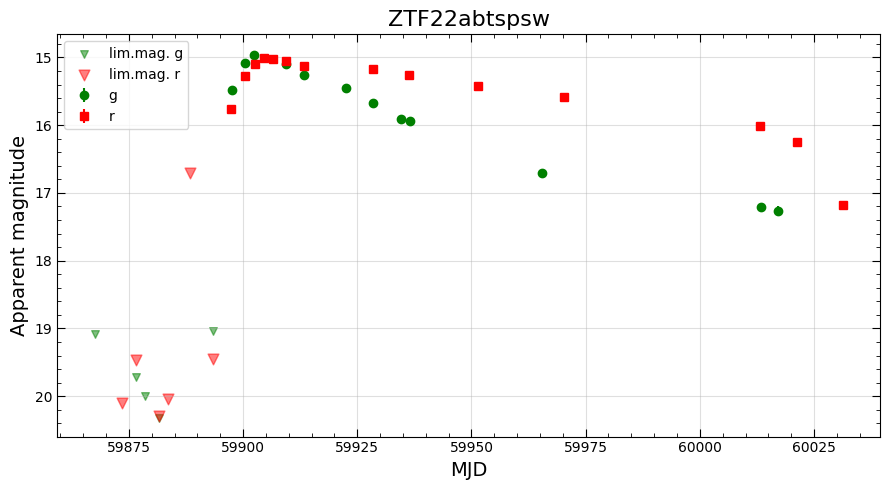

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/3494373774.py:59: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


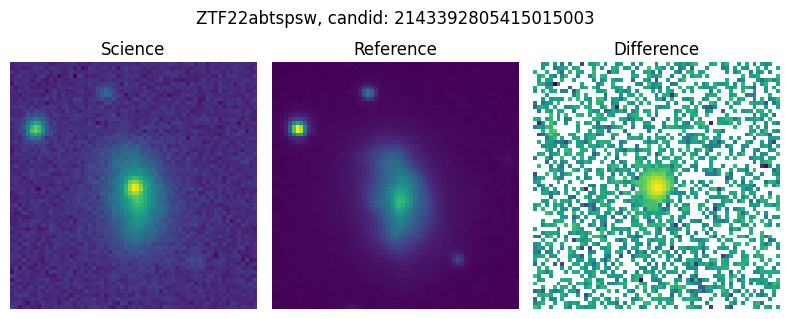

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/3494373774.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [181]:
alerce = Alerce()
res = get_ztf_lc_data('ZTF22abtspsw', alerce, doLC=True, doStamps=True, add_forced=True)

Ok I think the reason we are missing the tail is because ALeRCE only does non-detections before the first detection. So we might need to query forced photometry? **Look towards end of notebook for my attempt at plotting light curves from ZTF forced photometry**

Found ZTF forced photometry data from Das paper. They are found in `data/Das_forced_photometry_files`.

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2735315045.py:177: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


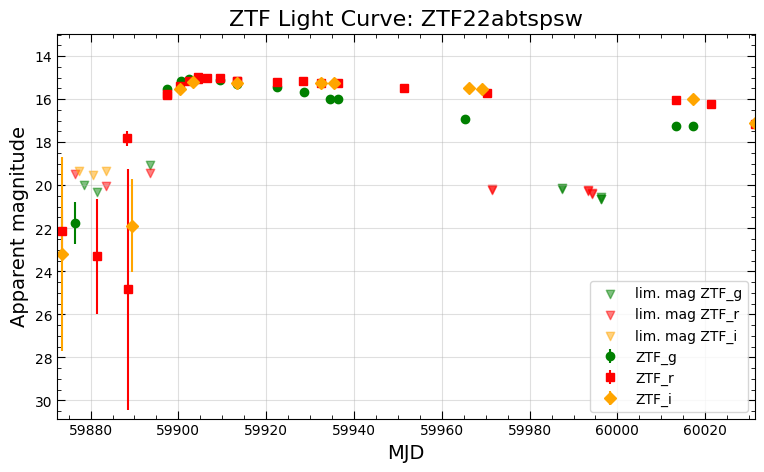

In [246]:
plot_forced_lc(res['forced'], oid=res['oid'], xlim=(res["lc_det"].mjd.min()-25, res["lc_det"].mjd.max()))

Now how about the IR data... Here are function to get WISE data and plot the lightcurve.

In [247]:
def get_wise_lc_data(oid):

    try:
        filename = glob.glob(f"data/ztf_snii_lcs_WISE/lightcurve_{oid}_*.json")[0]
    except IndexError:
        print(f"⚠️ No WISE light curve file found for {oid}")
        return {}

    f = open(filename, 'r')
    jfile = json.load(f)
    outmags = [jfile[j] for j in jfile.keys()]
    times = np.array([o['mjd'] for o in outmags])
    fluxes = np.array([o['psfflux'] for o in outmags])
    fluxerrs = np.array([o['psfflux_unc'] for o in outmags])
    bands = np.array([o['bandid'] for o in outmags])
    zps = np.array([o['zp'] for o in outmags])
    zpflux = np.zeros(len(bands))
    #create zero point fluxes in Jy as provided in the WISE official release supplements
    for i in range(len(bands)):
        if bands[i] == 1:
            zpflux[i] = 309
        else:
            zpflux[i] = 172
    zps = np.array([o['zp'] for o in outmags])
    mjy_fluxes = zpflux * 10**(-zps/2.5) * fluxes * 1e3
    mjy_fluxerrs = zpflux * 10**(-zps/2.5) * fluxerrs * 1e3
    snrs = fluxes/fluxerrs
    
    b1filt = (bands == 1)
    b2filt = (bands == 2)
    
    b1_times = times[b1filt]
    b1_fluxes = mjy_fluxes[b1filt]
    b1_fluxerrs = mjy_fluxerrs[b1filt]
    
    b2_times = times[b2filt]
    b2_fluxes = mjy_fluxes[b2filt]
    b2_fluxerrs = mjy_fluxerrs[b2filt]    
    
    resdict = {'b1_times': b1_times, 'b1_fluxes': b1_fluxes, 'b1_fluxerrs': b1_fluxerrs,
               'b2_times': b2_times, 'b2_fluxes': b2_fluxes, 'b2_fluxerrs': b2_fluxerrs}
    return resdict

def plot_wise_lc(resdict, oid="ZTF source", xlim=(None, None), ax=None, show=True):

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(9,5))
        created_ax = True

    colors = {1:"black",2:"red"}
    markers = {1:"o",2:"s"}

    for fid, data in zip([1,2], [("b1_times","b1_fluxes","b1_fluxerrs"), ("b2_times","b2_fluxes","b2_fluxerrs")]):
        color = colors.get(fid,"black")

        # --- Detections ---
        mask_det = ~np.isnan(resdict[data[1]])
        if np.any(mask_det):
            ax.errorbar(
                resdict[data[0]][mask_det],
                resdict[data[1]][mask_det],
                yerr=resdict[data[2]][mask_det],
                fmt="o", color=color, label=fid,
                marker = markers.get(fid, "o")
            )

    if created_ax:
        ax.set_title(f"WISE Light Curve: {oid}", fontsize=16)
        ax.set_xlabel("MJD", fontsize=14)
        ax.set_ylabel("WISE flux (mJy)", fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.4)
        
        if show:
            plt.show()

    if not created_ax:
        return ax

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


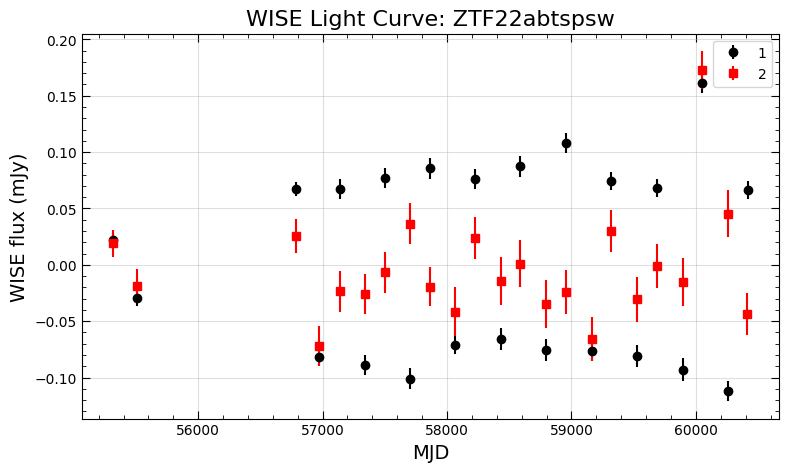

In [248]:
res_dict = get_wise_lc_data('ZTF22abtspsw')
plot_wise_lc(res_dict, oid="ZTF22abtspsw")

In [249]:
wise_res_dict = get_wise_lc_data('ZTF22abtspsw')
ztf_res_dict = get_ztf_lc_data('ZTF22abtspsw', alerce, doLC=False, doStamps=False, add_forced=True)

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2735315045.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [257]:
def plot_combined_lc(ztf_resdict, wise_resdict, oid="ZTF+WISE source", xlim=(None, None), ztf_flux=False):
    
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10,8), sharex=True,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    xlim=(ztf_resdict["lc_det"].mjd.min(), ztf_resdict["lc_det"].mjd.max())
    min_mjd = xlim[0] - 30 if xlim[0] is not None else None
    max_mjd = xlim[1] + 400 if xlim[1] is not None else None


    # -----------------
    # Top panel: ZTF LC
    # -----------------
    if ztf_flux:
        print("Converting ZTF mag to mJy...")
        ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)
        plot_forced_lc(ztf_resdict['forced'], oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax1, show=False, flux=True)
        ax1.set_ylabel("ZTF flux (mJy)", fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.4)
    else:
        plot_forced_lc(ztf_resdict['forced'], oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax1, show=False)
        ax1.set_ylabel("Apparent magnitude", fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.4)

    # -----------------
    # Bottom panel: WISE LC
    # -----------------
    if wise_resdict == {}:
        pass
    else:
        plot_wise_lc(wise_resdict, oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax2, show=False)
        ax2.set_ylabel("WISE flux (mJy)", fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.4)
        
        ax2.set_xlabel("MJD", fontsize=14)

    # -----------------
    # Final formatting
    # -----------------
    fig.subplots_adjust(hspace=0.0)
    fig.suptitle(f"ZTF + WISE Light Curve: {oid}", fontsize=16, y=0.93)
    plt.show()


Converting ZTF mag to mJy...


/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2735315045.py:177: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


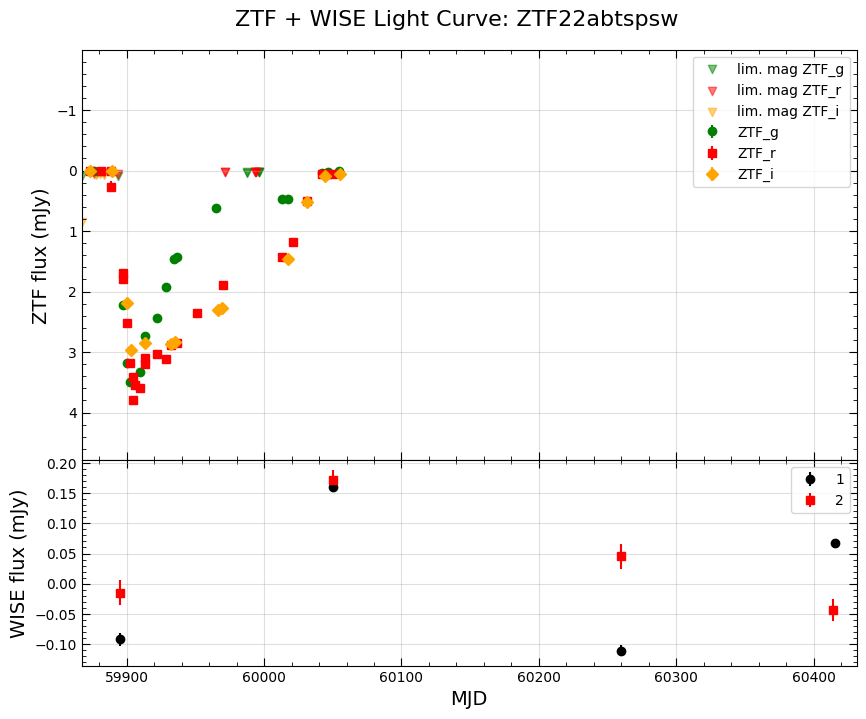

In [258]:
plot_combined_lc(ztf_res_dict, wise_res_dict, oid="ZTF22abtspsw", ztf_flux=True)

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


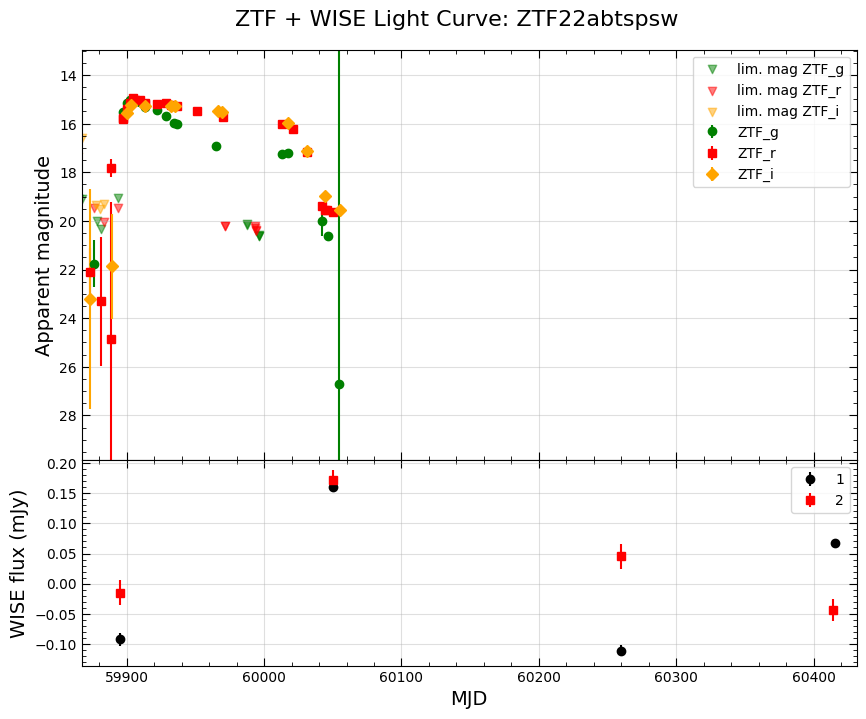

In [213]:
plot_combined_lc(ztf_res_dict, wise_res_dict, oid="ZTF22abtspsw")

ZTF22abtspsw


/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


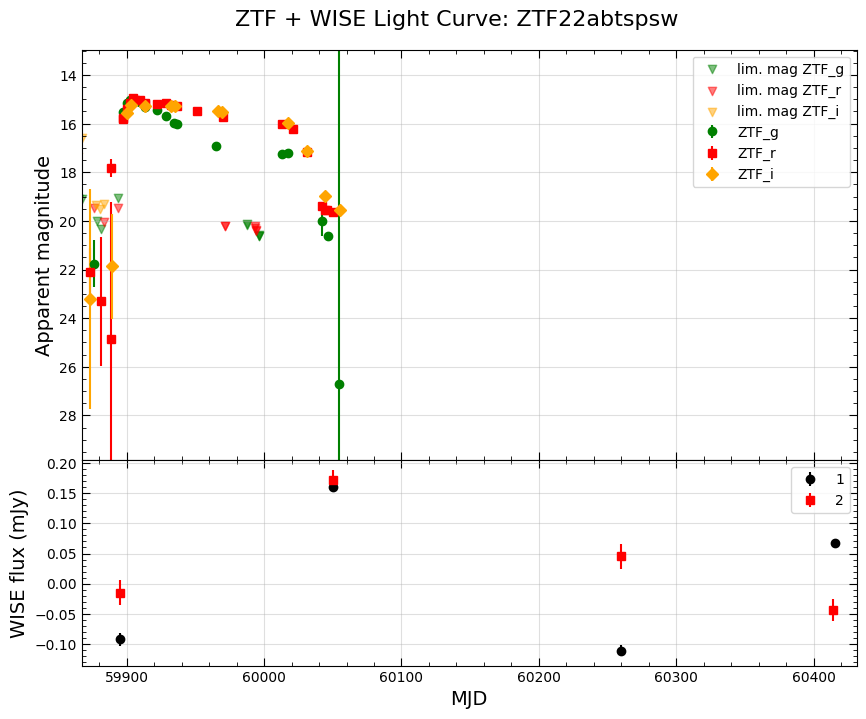

ZTF21abnlhxs


/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


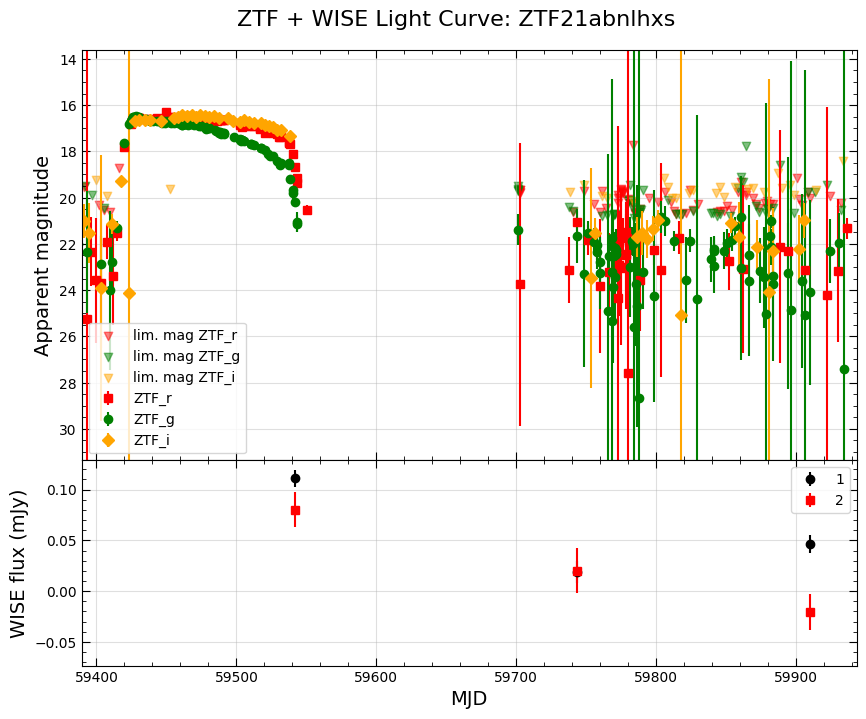

ZTF22aavobvq


/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


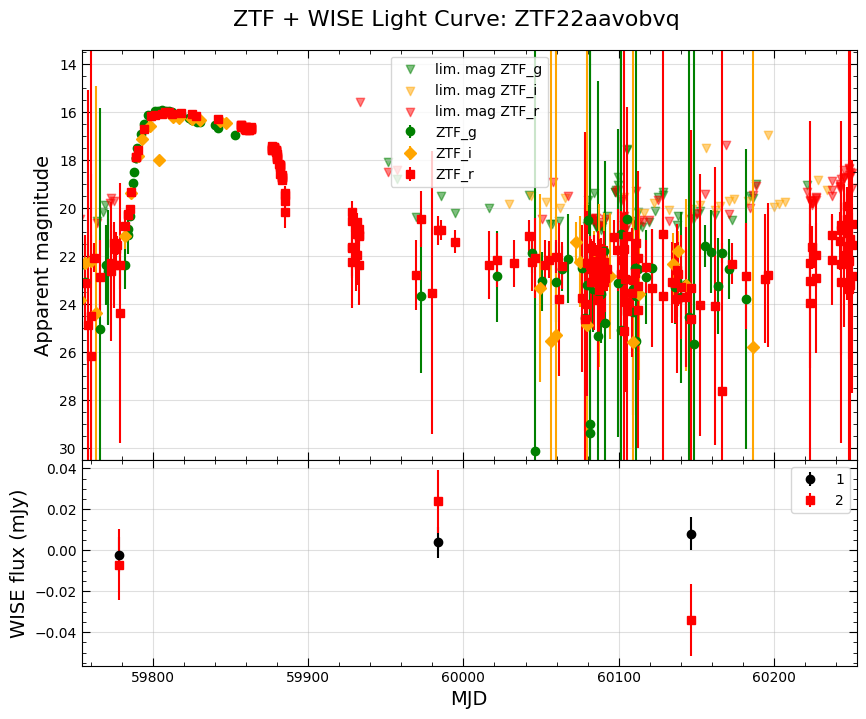

ZTF23abmoxlu


/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/677307180.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


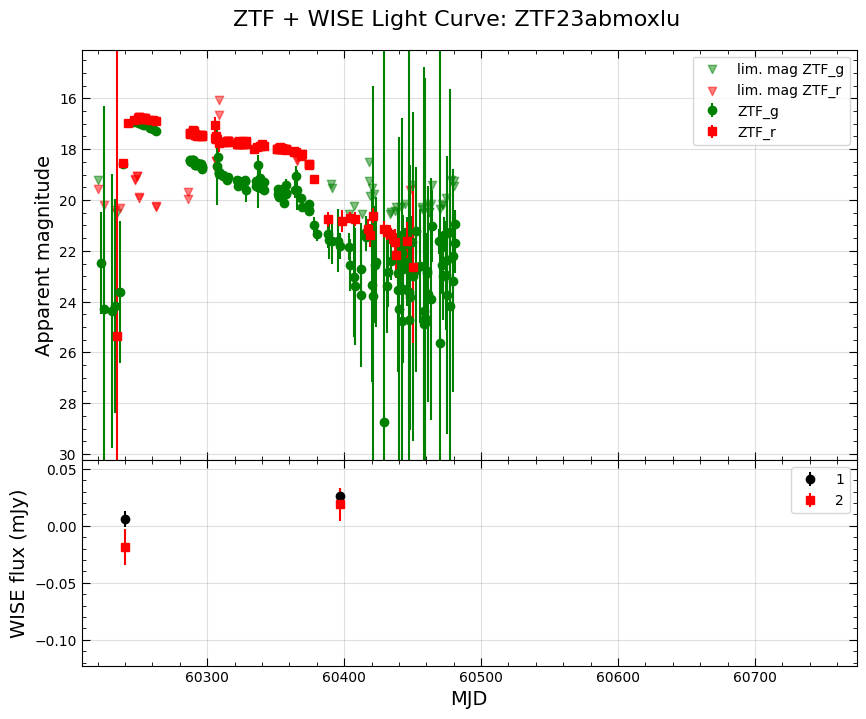

ZTF20aapchqy
⚠️ No WISE light curve file found for ZTF20aapchqy


/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2809497598.py:173: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


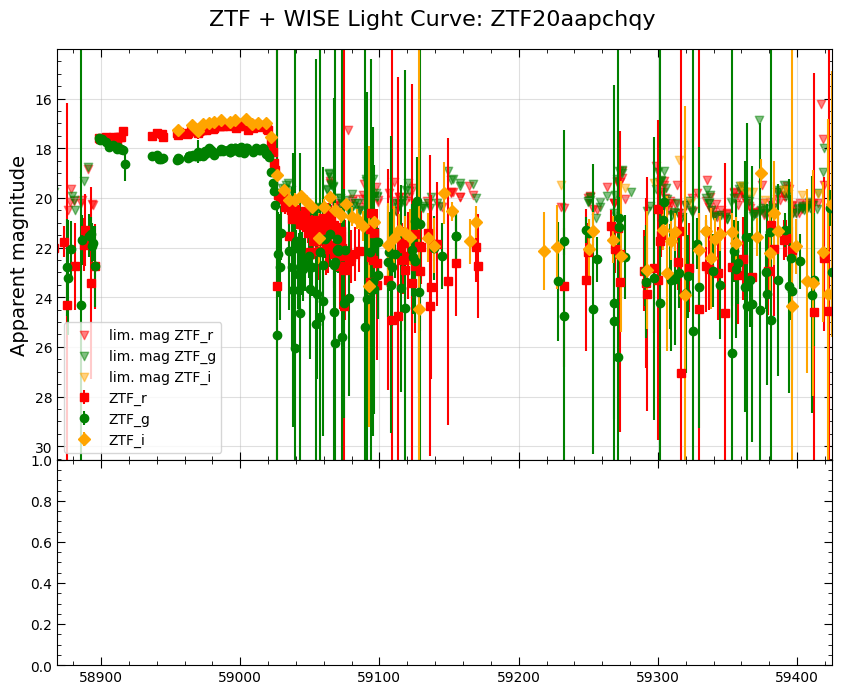

In [221]:
my_cands = np.load('my_candidates.npy', allow_pickle=True)


for cand in my_cands[:5]:
    print(cand)
    wise_res_dict = get_wise_lc_data(cand)
    ztf_res_dict = get_ztf_lc_data(cand, alerce, doLC=False, doStamps=False, add_forced=True)
    plot_combined_lc(ztf_res_dict, wise_res_dict, oid=cand)

In [253]:
ztf_res_dict = get_ztf_lc_data('ZTF22abtspsw', alerce, doLC=False, doStamps=False, add_forced=True)

/var/folders/l7/r0rjx3_15fq7rrl6h9w8mnrw0000gn/T/ipykernel_1151/2735315045.py:119: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [255]:
ztf_res_dict['lc_det'].keys()

Index(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magap', 'sigmapsf', 'sigmagap', 'ra', 'dec', 'rb',
       'rbversion', 'drb', 'magapbig', 'sigmagapbig', 'rfid', 'has_stamp',
       'corrected', 'dubious', 'step_id_corr', 'phase', 'parent_candid',
       'flux_mJy', 'flux_err_mJy'],
      dtype='object')

Let's convert AB mag of our ZTF data to mJy.

In [254]:
ztf_res_dict = convert_ZTF_mag_mJy(ztf_res_dict, forced=False)